In [38]:
import numpy as np
import pandas as pd
from scipy.optimize import root_scalar
from scipy.io import loadmat
import numpy as np
from scipy.optimize import root_scalar

In [94]:
data = pd.read_csv('data.csv')

In [95]:
#remoe the spaces from all the entries in the dataframe
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

#remove the spaces from the headers
data.columns = data.columns.str.strip()

#set all the entries except Date to float
for col in data.columns:
    if col != 'Date':
        data[col] = data[col].astype(float)




/var/folders/hb/bc0srnt52zx6lbw4t2k_t_k80000gn/T/ipykernel_59499/732381974.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [96]:
df = data.copy()

In [133]:
#rename Risk.free to rb
df.rename(columns={'Risk-free': 'rb'}, inplace=True)

#compute stock gross returns
df['rs'] = df['SP500'].shift(-1) / df['SP500']

#compute Dividend Growth
df['DivGrowth'] = df['Dividend'].shift(-1) / df['Dividend']

#compute Price-Dividend ratio
df['PD'] = df['SP500'] / df['Dividend']

#compute Gross return including dividends
df['Rs'] = (df['SP500'].shift(-1) + df['Dividend'].shift(-1)) / df['SP500']

#remove rows with NaN values
df.dropna(inplace=True)

In [134]:
#keep only the last 50 years, (12*50 = 600 months)
df = df.tail(600)

<Axes: >

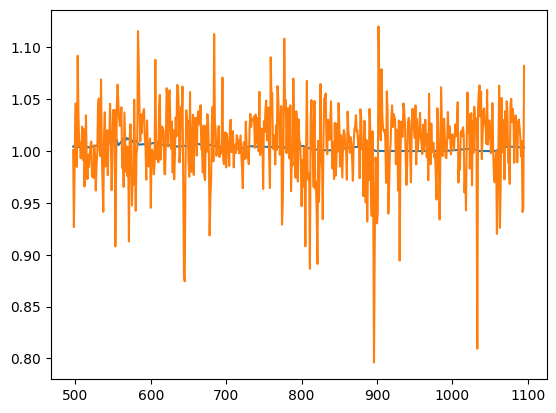

In [135]:
df['rb'].plot()
df['rs'].plot()

In [143]:
# === 1. given or estimated from data ===
a = np.mean(df["rs"])    #np.mean(df["DivGrowth"]) #               
s2_d = np.log(df['rs'].var() / a**2 + 1)  #np.log(df['DivGrowth'].var() / a**2 + 1) ##np.var(np.log(df["DivGrowth"])) 
sd = np.sqrt(s2_d)         
sc = sd / 7
rho = 0.2                
rf_gross = df["rb"].to_numpy()  
Rf = np.mean(rf_gross)
Gross_return = np.mean(df['rs'])                      
pd_data = np.mean(df["PD"])
Rs = np.mean(df['Rs'])

# === 2. print parameters ===
print("=" * 50)
print("Model Parameters:")
print("=" * 50)
print(f"Mean gross return (a):        {a:.4f}")
print(f"Std dev log div growth (sd):  {sd:.4f}")
print(f"Std dev log cons growth (sc): {sc:.4f}")
print(f"Correlation (rho):            {rho:.4f}")
print(f"Mean risk-free rate (Rf):     {Rf:.4f}")
print(f"Mean gross return (E[R]):     {Gross_return:.4f}")
print(f"Mean dividend growth:        {np.mean(df["DivGrowth"]):.4f}")
print(f"Empirical P/D ratio:          {pd_data:.2f}")
print("=" * 50)


# === 3. model functions ===
def rho_e(gamma, sc, sd, rho):
    return np.exp(0.5 * gamma * (1 + gamma) * sc**2 - gamma * rho * sc * sd)

def delta_from_gamma(gamma, a, sc, Rf):
    return (Rf ** -1) * (a ** gamma) * np.exp(-0.5 * gamma * (1 + gamma) * sc**2)

def delta_from_gamma_equity(gamma, a, rho_e, Rs):
    return (Rs ** -1) * (a ** - gamma * rho_e) ** -1

def pd_ratio_model(gamma, a, sd, sc, rho, Rf, Rs, type='risk-free'):
    if type == 'equity':
        delta = delta_from_gamma_equity(gamma, a, rho_e(gamma, sc, sd, rho), Rs)
    elif type == 'risk-free':
        delta = delta_from_gamma(gamma, a, sc, Rf)
    else:
        raise ValueError("type must be either 'equity' or 'risk-free'")
    rhoE = rho_e(gamma, sc, sd, rho)
    numerator = delta * (a ** (1 - gamma)) * rhoE
    denominator = 1 - (a ** (1 - gamma)) * rhoE
    return numerator / denominator

# === 3. root-finding objective ===
def objective(gamma):
    return pd_ratio_model(gamma, a, sd, sc, rho, Rf, Rs) - pd_data


# === 4. solve for gamma ===
sol = root_scalar(objective, bracket=[0.9999, 200],  method='brentq', xtol=1e-12)
gamma_star =  sol.root
delta_star = delta_from_gamma(gamma_star, a, sc, Rf)

print(f"Calibrated gamma = {gamma_star:.4f}")
print(f"Implied delta   = {delta_star:.4f}")
print(f"Model P/D check = {pd_ratio_model(gamma_star, a, sd, sc, rho, Rf, Rs):.2f}")


Model Parameters:
Mean gross return (a):        1.0076
Std dev log div growth (sd):  0.0352
Std dev log cons growth (sc): 0.0050
Correlation (rho):            0.2000
Mean risk-free rate (Rf):     1.0035
Mean gross return (E[R]):     1.0076
Mean dividend growth:        1.0051
Empirical P/D ratio:          45.30
Calibrated gamma = 3.9825
Implied delta   = 1.0267
Model P/D check = 45.30


In [ ]:
(a ** gamma_star) * np.exp(-0.5 * gamma_star * (1 + gamma_star) * sc**2 )

np.float64(1.0304124589312733)

In [13]:
print(f"\nDelta range check:")
print(f"Delta at gamma=1:   {delta_from_gamma(1, a, sc, Rf):.4f}")
print(f"Delta at gamma=10:  {delta_from_gamma(10, a, sc, Rf):.4f}")
print(f"Delta at gamma=50:  {delta_from_gamma(50, a, sc, Rf):.4f}")


Delta range check:
Delta at gamma=1:   1.0082
Delta at gamma=10:  1.2056
Delta at gamma=50:  2.0843


In [8]:
print(f"\nParameter diagnostics:")
print(f"a (mean gross div growth) = {a:.6f}")
print(f"sc (cons volatility) = {sc:.6f}")
print(f"sc^2 = {sc**2:.8f}")
print(f"Rf (risk-free rate) = {Rf:.6f}")
print(f"1/Rf = {1/Rf:.6f}")

# Check the components separately
gamma_test = 50
print(f"\nAt gamma = {gamma_test}:")
print(f"1/Rf term = {1/Rf:.6f}")
print(f"a^gamma term = {a**gamma_test:.6f}")
exp_term = np.exp(-0.5 * gamma_test * (1 + gamma_test) * sc**2)
print(f"exp() dampening term = {exp_term:.6f}")
print(f"Product (delta) = {(1/Rf) * (a**gamma_test) * exp_term:.6f}")


Parameter diagnostics:
a (mean gross div growth) = 1.021602
sc (cons volatility) = 0.015874
sc^2 = 0.00025197
Rf (risk-free rate) = 1.001331
1/Rf = 0.998671

At gamma = 50:
1/Rf term = 0.998671
a^gamma term = 2.911291
exp() dampening term = 0.725230
Product (delta) = 2.108548


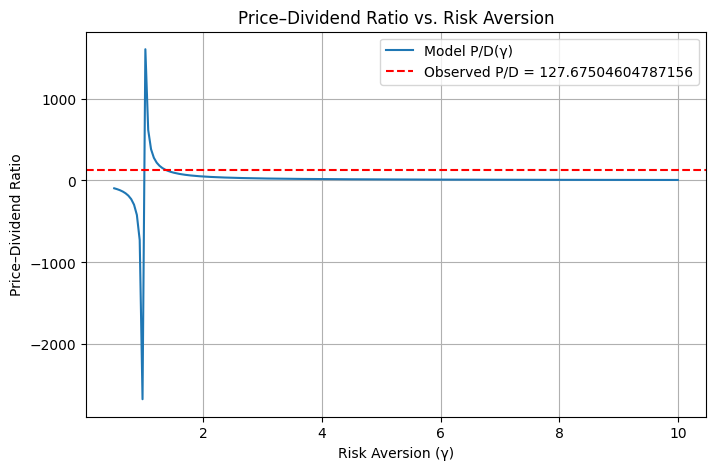

In [9]:
import numpy as np
import matplotlib.pyplot as plt

gammas = np.linspace(0.5, 10, 200)   # range of risk aversion values
pd_model_vals = [pd_ratio_model(g, a, sd, sc, rho, Rf) for g in gammas]

plt.figure(figsize=(8,5))
plt.plot(gammas, pd_model_vals, label="Model P/D(γ)")
plt.axhline(pd_data, color='r', linestyle='--', label=f"Observed P/D = {pd_data}")
plt.xlabel("Risk Aversion (γ)")
plt.ylabel("Price–Dividend Ratio")
plt.title("Price–Dividend Ratio vs. Risk Aversion")
plt.legend()
plt.grid(True)
plt.show()


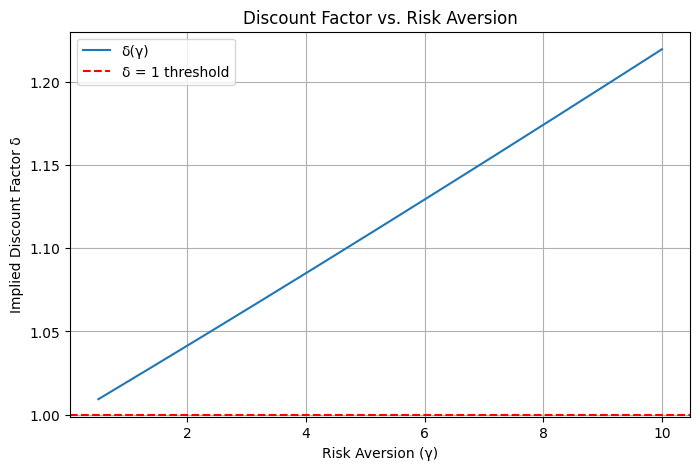

In [10]:
deltas = [delta_from_gamma(g, a, sc, Rf) for g in gammas]

plt.figure(figsize=(8,5))
plt.plot(gammas, deltas, label="δ(γ)")
plt.axhline(1.0, color='r', linestyle='--', label="δ = 1 threshold")
plt.xlabel("Risk Aversion (γ)")
plt.ylabel("Implied Discount Factor δ")
plt.title("Discount Factor vs. Risk Aversion")

plt.legend()
plt.grid(True)
plt.show()


In [11]:
import numpy as np
cross_idx = np.argmin(np.abs(np.array(deltas) - 1))
print(f"δ ≈ 1 at γ ≈ {gammas[cross_idx]:.2f}")


δ ≈ 1 at γ ≈ 0.50
